# Mouse Cerebellum (Slideseq-V2)

In [2]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scanpy as sc

import sys
sys.path.append('../src')
from utils import *
import pickle

import warnings
warnings.filterwarnings('ignore')

## Preprocessing scRNA-ref

Ideally, the scRNAseq reference should from the exact same tissue that contains all the celltypes you expect to find in ST spots.

We will use a Mouse cerebellum scRNA-seq as reference dataset, the raw dataset in h5ad format (scRefSubsampled1000_cerebellum_singlenucleus.h5ad) is available in [here](https://singlecell.broadinstitute.org/single_cell/study/SCP948).

Conveniently, we provided the pre-pocessed scRNA-ref (Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad) as well as other relevent materials involved in the following example in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg?usp=sharing), so you can skip this part

In [3]:
ad_sc = sc.read('scRefSubsampled1000_cerebellum_singlenucleus.h5ad')

ad_sc.obs['cell_type'] = ad_sc.obs['liger_ident'].map(lambda x:x.split('_')[-1])
cell_type_column = 'cell_type'

sc.pp.filter_cells(ad_sc, min_counts=500)
sc.pp.filter_cells(ad_sc, max_counts=20000)
sc.pp.filter_genes(ad_sc, min_cells=10)
ad_sc = ad_sc[:,~np.array([_.startswith('MT-') for _ in ad_sc.var.index])]
ad_sc = ad_sc[:,~np.array([_.startswith('mt-') for _ in ad_sc.var.index])]

ad_sc.X.max(),ad_sc.shape

(7175.0, (14748, 20179))

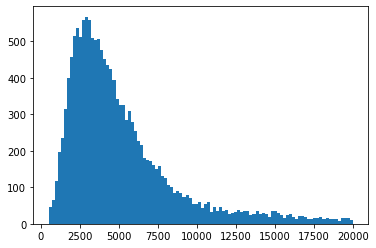

In [4]:
if ad_sc.X.max()<20:
    ad_sc.X = np.exp(ad_sc.X)-1
plt.hist(ad_sc.X.sum(1),bins=100)
plt.show()

In [5]:
ad_sc.raw = ad_sc.copy()
sc.pp.normalize_total(ad_sc, inplace=True, target_sum=5e3)

sc.pp.highly_variable_genes(ad_sc, flavor='seurat_v3',n_top_genes=1000)
sc.tl.rank_genes_groups(ad_sc, groupby=cell_type_column, method='wilcoxon')
markers_df = pd.DataFrame(ad_sc.uns["rank_genes_groups"]["names"]).iloc[0:50, :]
markers = list(np.unique(markers_df.melt().value.values))
markers = list(set(ad_sc.var.loc[ad_sc.var['highly_variable']==1].index)|set(markers)) # highly variable genes + cell type marker genes

ligand_recept = list(set(pd.read_csv('../extdata/ligand_receptors.txt',sep='\t').melt()['value'].values))
# if scRNA-seq reference is from human tissue, run following code to make gene name consistent
# ligand_recept = [_.upper() for _ in ligand_recept]
add_genes = ['Cadm3','Ptprt','Aldoc','Gria1'] # some important genes that we interested

markers = markers+add_genes+ligand_recept
len(markers)

2217

In [6]:
ad_sc.var.loc[ad_sc.var.index.isin(markers),'Marker'] = True
ad_sc.var['Marker'] = ad_sc.var['Marker'].fillna(False)
ad_sc.var['highly_variable'] = ad_sc.var['Marker']

sc.pp.log1p(ad_sc)
sc.pp.pca(ad_sc,svd_solver='arpack', n_comps=30, use_highly_variable=True)

ad_sc.X.max()

7.6586394

In [7]:
sc.pp.neighbors(ad_sc, metric='cosine', n_neighbors=30, n_pcs = 30)
sc.tl.umap(ad_sc, min_dist = 0.5, spread = 1, maxiter=60)

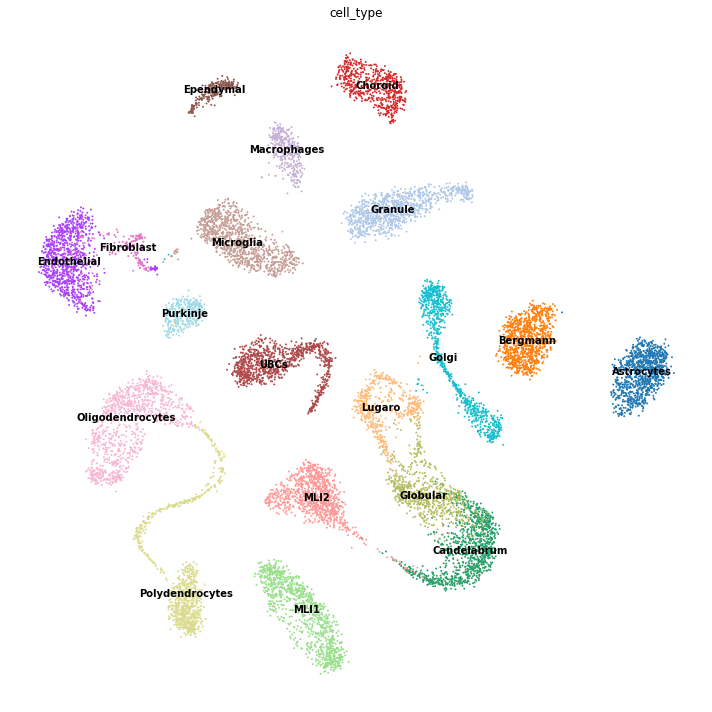

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.umap(
    ad_sc, color=cell_type_column, size=15, frameon=False, show=False, ax=axs,legend_loc='on data'
)
plt.tight_layout()

In [9]:
#ad_sc.write('../Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad')

## Run SpatialScope

### Step1: Singlet Doublet Classification

Because Slide-seq data lacks paired histological image, we replace the first step ”Nuclei segmentation” with ”Singlet/Doublet classification” inspired by RCTD. Of note, this step is also applicable to other high resolution ST data such as HDST, DBiT-seq etc.

python ./src/Singlet_Doublet_Classification.py \
            --cell_class_column cell_type \
            --tissue cere \
            --out_dir ./output \
            --ST_Data ./demo_data/slideseq-cerebellum.h5ad \
            --SC_Data ./Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad 

### Step2: Cell type identification

python ./src/Cell_Type_Identification.py \
            --cell_class_column cell_type \
            --tissue cere \
            --out_dir ./output \
            --ST_Data ./output/cere/sp_adata_sdc.h5ad \
            --SC_Data ./Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad \
            --hs_ST 

### Step 3: Gene expression decomposition

set -ex;

declare -a arr=("0,1000" "1000,2000" "2000,3000" "3000,4000" "4000,5000" "5000,6000" "6000,7000" "7000,8000" "8000,9000" "9000,10000" "10000,11000" "11000,11626")

for i in "${arr[@]}"

do

python ./src/Decomposition.py \
--tissue cere \
--out_dir ./output \
--SC_Data ./Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad \
--cell_class_column cell_type  \
--ckpt_path ./Ckpts_scRefs/Cerebellum/model_540001.pt \
--spot_range $i \
--gpu 2,3,4,8 \


done

## Cell type identification result (Fig. a)

In [114]:
ad_sp = sc.read('../output/cere/sp_adata.h5ad')
ad_sc = sc.read('../Ckpts_scRefs/Cerebellum/Ref_snRNA_cerebellum_qc.h5ad')

In [110]:
ad_sp.uns['cell_locations'].head()

,spot_index,spot_class,first_type,second_type,min_score,singlet_score,first_type_weight,second_type_weight,x,y,cell_nums,cell_index,cell_index_n,cell_type,discrete_label,discrete_label_ct
0,GCCTTGCTGAGCTC,singlet,Bergmann,Granule,445.194605,463.437230,0.824780,0.175220,1632.575000,3463.375000,1,GCCTTGCTGAGCTC_0,0,Bergmann,1,Bergmann
1,GGTTCGCGACCACA,singlet,Granule,Ependymal,237.770038,252.347030,0.745520,0.254480,3078.088889,1795.177778,1,GGTTCGCGACCACA_0,0,Granule,9,Granule
2,CAGAGGCTTTTTTT,singlet,Astrocytes,Granule,378.295186,383.238369,0.882583,0.117417,4682.637363,2342.197802,1,CAGAGGCTTTTTTT_0,0,Astrocytes,0,Astrocytes
3,CTTCGGATTTTTTT,singlet,Oligodendrocytes,Astrocytes,327.364298,327.304644,0.998508,0.001492,4178.563830,2645.021277,1,CTTCGGATTTTTTT_0,0,Oligodendrocytes,15,Oligodendrocytes
4,TGTGGGGAATTTTT,singlet,Granule,Bergmann,207.347290,208.740884,0.950068,0.049932,2757.945652,1932.380435,1,TGTGGGGAATTTTT_0,0,Granule,9,Granule


In [108]:
color_dict = {'Astrocytes': '#1f77b4',
 'Bergmann': '#ff7f0e',
 'Granule': '#2ca02c',
 'Purkinje': '#d62728',
 'MLI2': '#9467bd',
 'MLI1': '#8c564b',
 'Oligodendrocytes': '#e377c2',
 'Lugaro': '#7f7f7f',
 'Polydendrocytes': '#bcbd22',
 'Golgi': '#17becf',
 'Candelabrum': '#98df8a',
 'Globular': '#f7b6d2',
 'Microglia': '#aec7e8',
 'Macrophages': '#dbdb8d',
 'Choroid': '#c7c7c7',
 'UBCs': '#c49c94',
 'Ependymal': '#9edae5',
 'Fibroblast': '#ff9896',
 'Endothelial': '#ffbb78'}

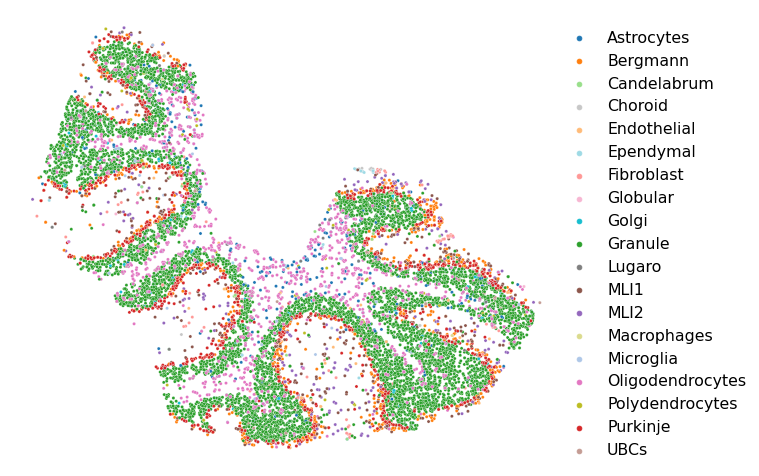

In [111]:
plt.subplots(figsize=(10,8.5))
sns.scatterplot(data=ad_sp.uns['cell_locations'], x="x", y="y",s=10,hue='discrete_label_ct',palette=color_dict,hue_order=np.unique(res_p2['cell_type']),legend=True)#rocket_r
plt.axis('off')
plt.legend(bbox_to_anchor=(0.97, .98),framealpha=0)
plt.show()

In [134]:
ad_sp.shape

(11626, 2312)

## Dropouts correction (Fig. d)

In [140]:
# We start by concatenating all the generated_cells_spotX_X.h5ad together
ad_scst = ConcatCells(s=0,e=12000,inter=1000,es=11626,file_path='../output/cere/',prefix='generated_cells_spot',suffix='.h5ad')

In [189]:
sc.pp.log1p(ad_scst)
sc.pp.log1p(ad_sp)

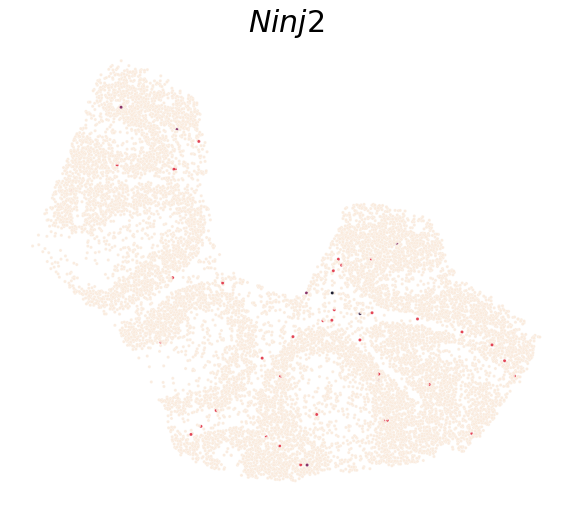

In [192]:
gene = 'Ninj2'
VisualDE(ad_sp,gene,0)

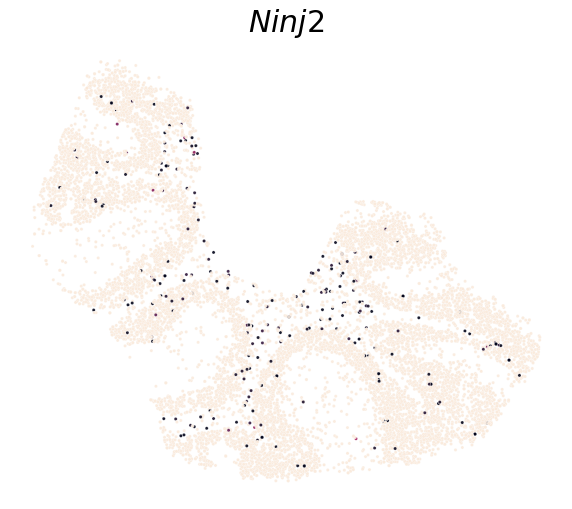

In [195]:
VisualDE(ad_scst,gene,.01)

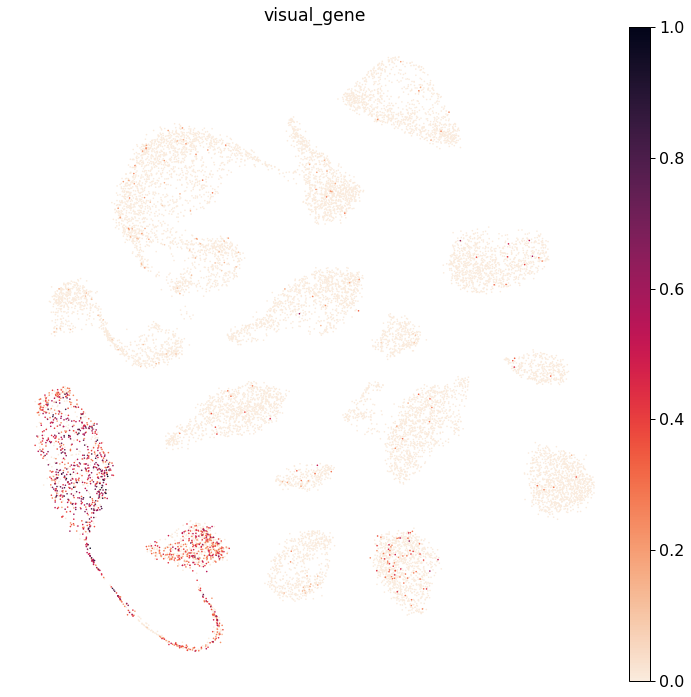

In [173]:
VisualscDE(ad_sc,gene)

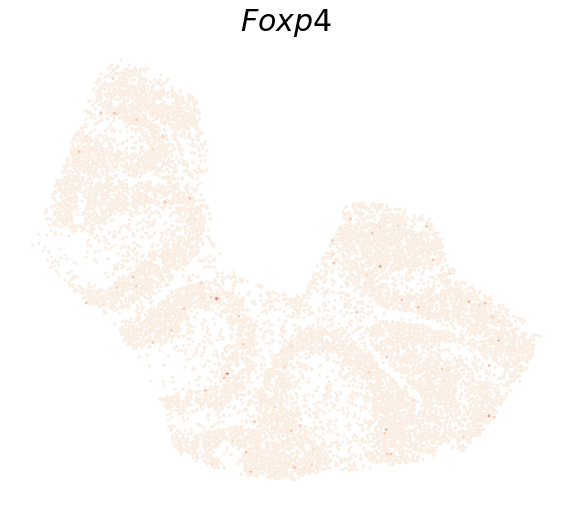

In [182]:
gene = 'Foxp4'
VisualDE(ad_sp,gene,0)

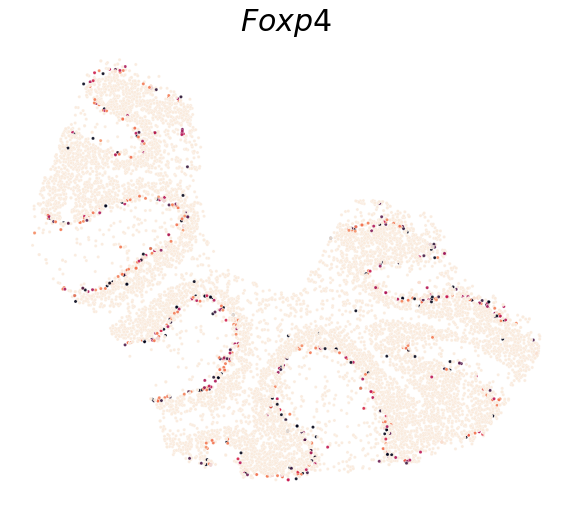

In [181]:
VisualDE(ad_scst,gene,0.01)

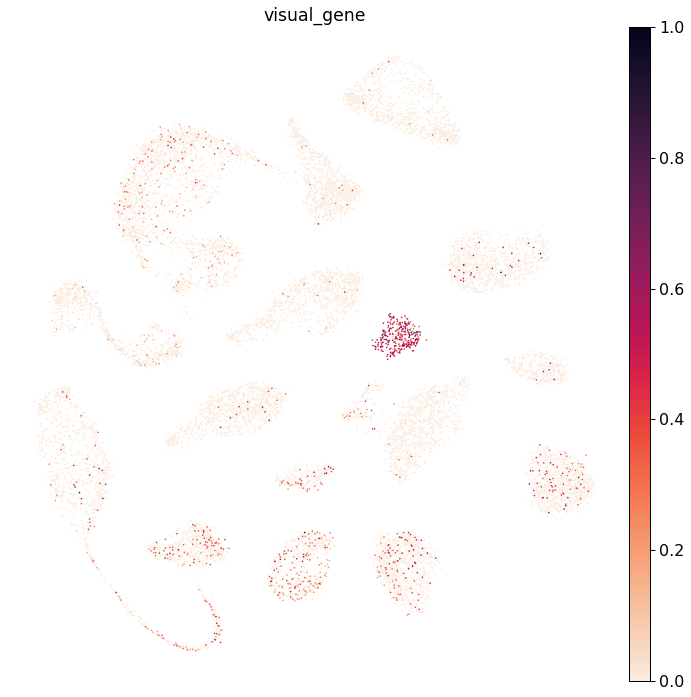

In [183]:
VisualscDE(ad_sc,gene)

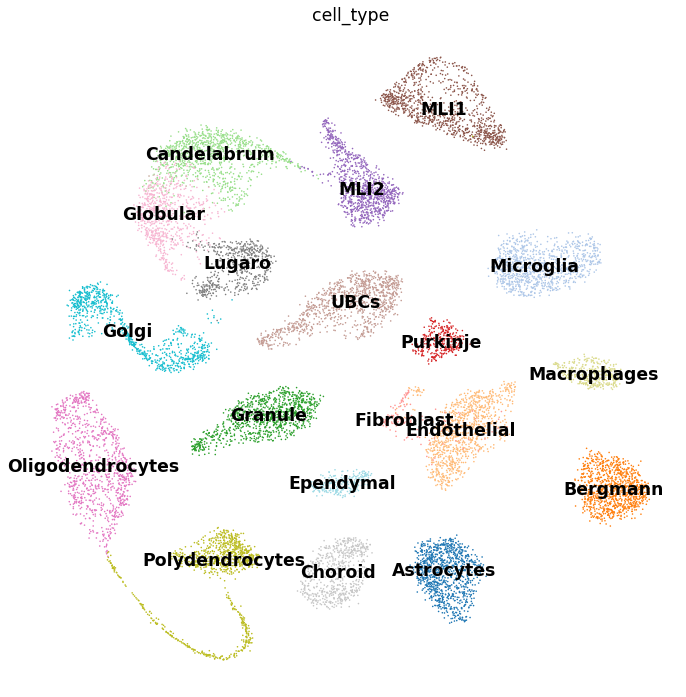

In [155]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.umap(
    ad_sc, color="cell_type", size=10, frameon=False, show=False, ax=axs,legend_loc='on data',palette=color_dict
)
plt.tight_layout()

## Cellular communications detection

refer to cell-cell interaction analysis in Human heart and Human-Heart-CCell-interaction.ipynb

### Representative examples (Fig. f)

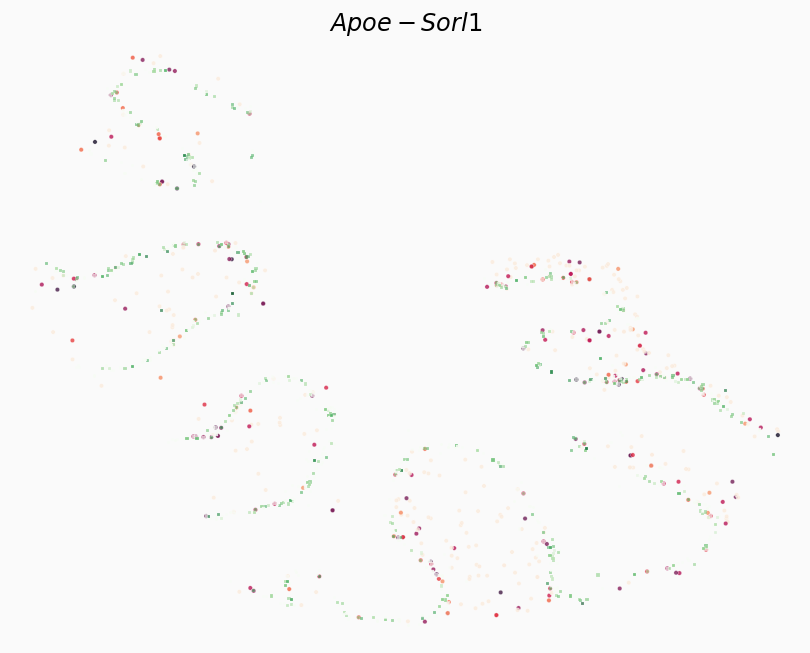

In [196]:
L_gene,R_gene,L_ct,R_ct = 'Apoe','Sorl1','MLI2','Purkinje'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='#fafafa')
PlotLRGenes(ad_scst,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=10)

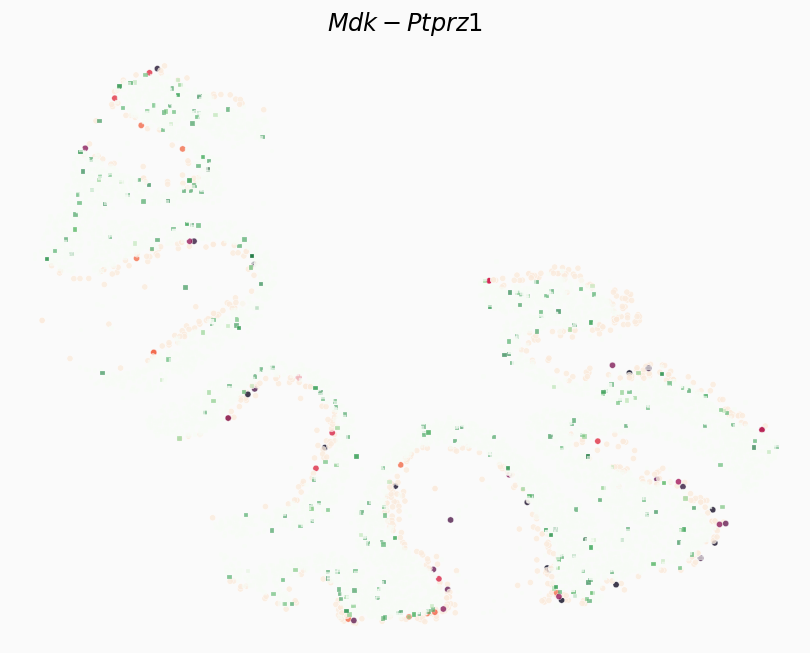

In [198]:
L_gene,R_gene,L_ct,R_ct = 'Mdk','Ptprz1','Bergmann','Granule'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='#fafafa')
PlotLRGenes(ad_scst,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=20)

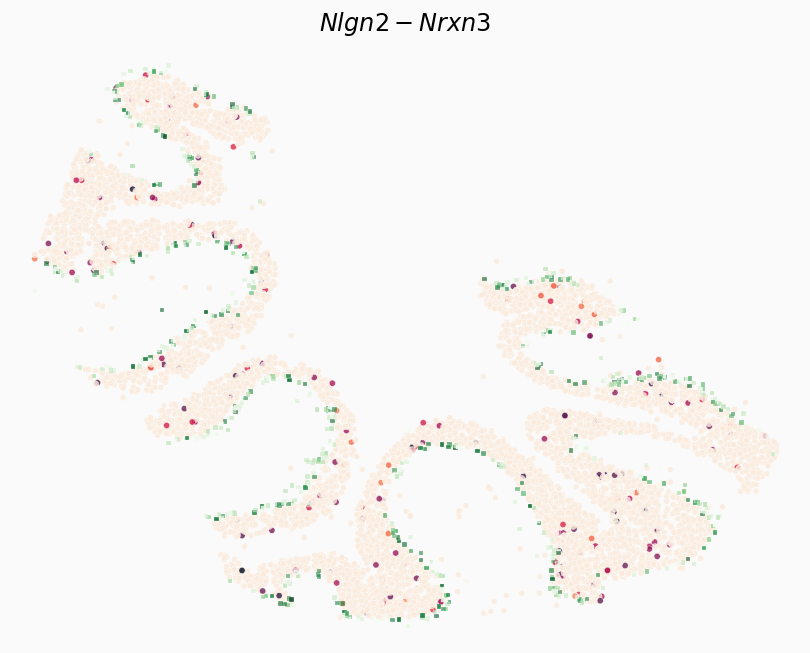

In [199]:
L_gene,R_gene,L_ct,R_ct = 'Nlgn2','Nrxn3','Granule','Purkinje'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='#fafafa')
PlotLRGenes(ad_scst,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=20)

## Cellular communications only detected in the corrected Slide-seq data by SpatialScope (Fig. g)

In [208]:
with open('../output/cere/InitProp.pickle', 'rb') as handle:
    InitProp = pickle.load(handle)

In [212]:
ad_sp.obs = ad_sp.obs.merge(InitProp['results']['results_df'][['spot_class','first_type','second_type']],left_index=True,right_index=True,how='left')

In [215]:
ad_sp.obs['discrete_label_ct'] = ad_sp.obs['first_type']

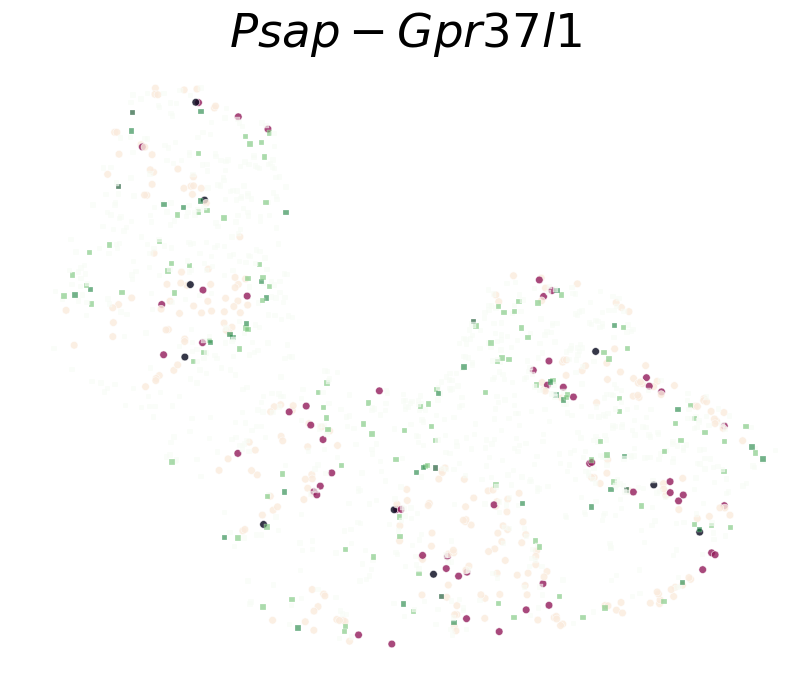

In [224]:
sns.set_context('paper',font_scale=3.5)
L_gene,R_gene,L_ct,R_ct = 'Psap','Gpr37l1','MLI1','Astrocytes'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='white')
PlotLRGenes(ad_sp,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=30,perc=0.01)

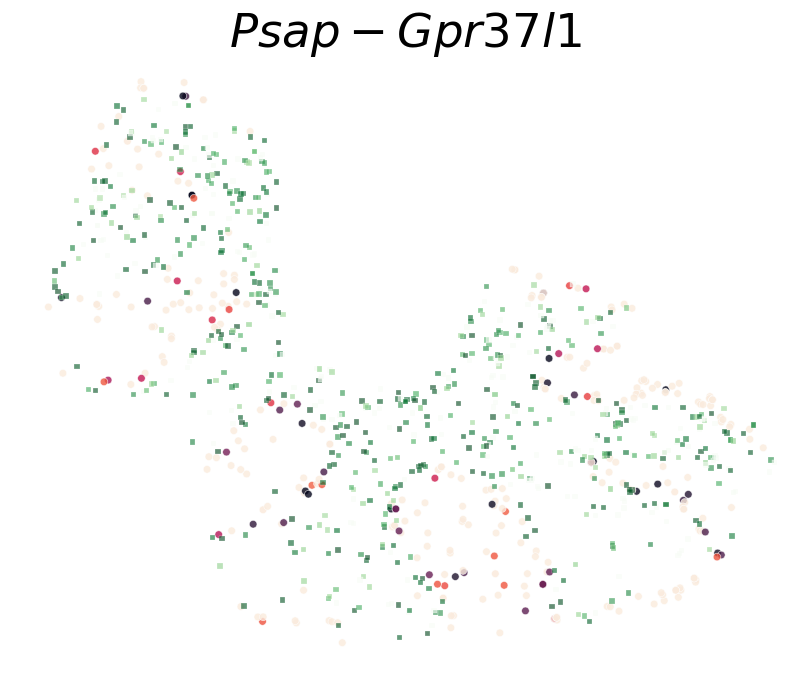

In [225]:
sns.set_context('paper',font_scale=3.5)
L_gene,R_gene,L_ct,R_ct = 'Psap','Gpr37l1','MLI1','Astrocytes'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='white')
PlotLRGenes(ad_scst,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=30,perc=0.01)

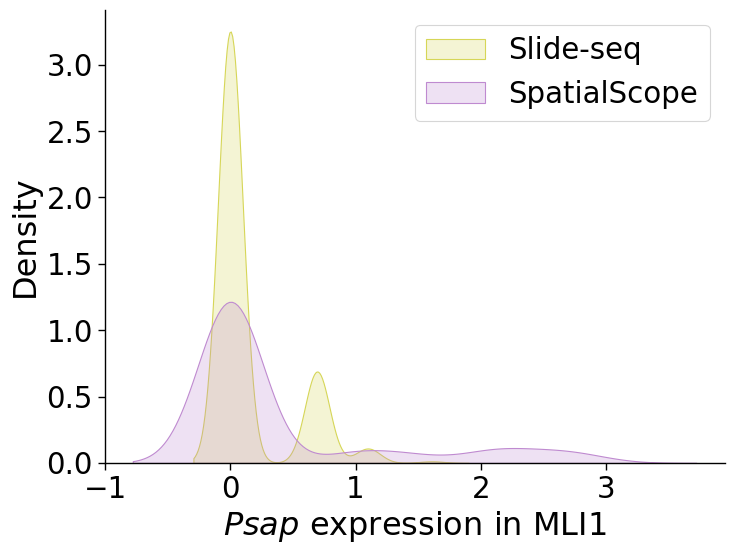

In [217]:
gene = L_gene
celltype = L_ct
sns.set_context('paper',font_scale=2.4)
fig, ax = plt.subplots(1, 1, figsize=(8, 6),dpi=100)
sns.kdeplot(data=ad_sp[ad_sp.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#D6D657',label='Slide-seq')
sns.kdeplot(data=ad_scst[ad_scst.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#BF8AD0',label='SpatialScope',clip=[-1,10])
ax.set_xlabel('${}$ expression in {}'.format(gene,celltype))
plt.legend(loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

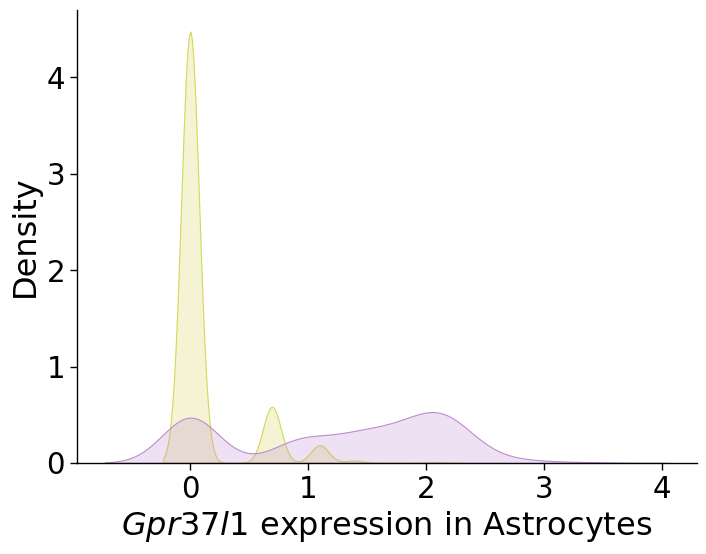

In [218]:
gene = R_gene
celltype = R_ct
sns.set_context('paper',font_scale=2.4)
fig, ax = plt.subplots(1, 1, figsize=(8, 6),dpi=100)
sns.kdeplot(data=ad_sp[ad_sp.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#D6D657',label='Slide-seq')
sns.kdeplot(data=ad_scst[ad_scst.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#BF8AD0',label='SpatialScope',clip=[-1,10])
ax.set_xlabel('${}$ expression in {}'.format(gene,celltype))
#plt.legend(loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

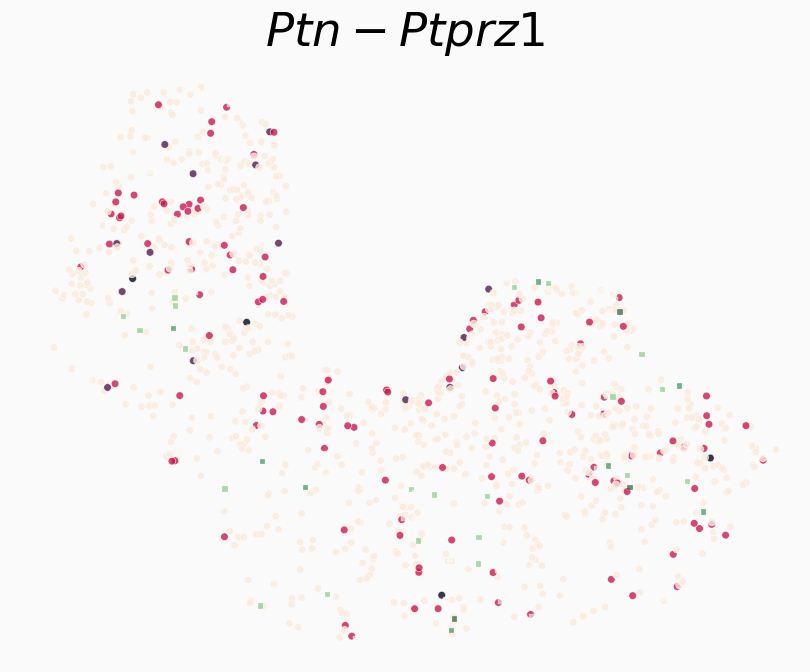

In [222]:
sns.set_context('paper',font_scale=3.5)
L_gene,R_gene,L_ct,R_ct = 'Ptn','Ptprz1','Astrocytes','MLI2'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='#fafafa')
PlotLRGenes(ad_sp,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=30)

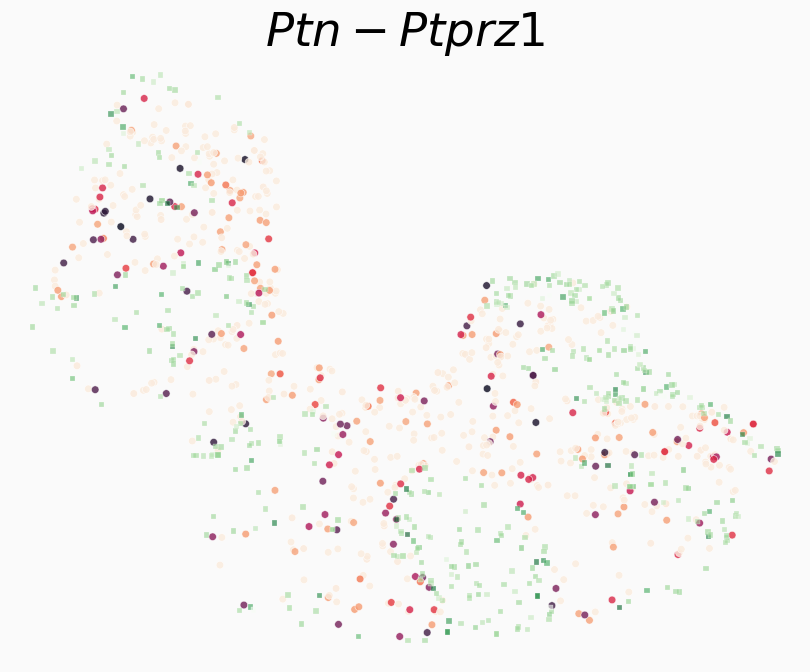

In [223]:
sns.set_context('paper',font_scale=3.5)
L_gene,R_gene,L_ct,R_ct = 'Ptn','Ptprz1','Astrocytes','MLI2'
fig, ax = plt.subplots(1, 1, figsize=(10.2, 8),dpi=100,facecolor='#fafafa')
PlotLRGenes(ad_scst,L_gene,R_gene,L_ct,R_ct,title='${}$'.format(L_gene+'-'+R_gene),ax=ax,invertY=False,s=30)

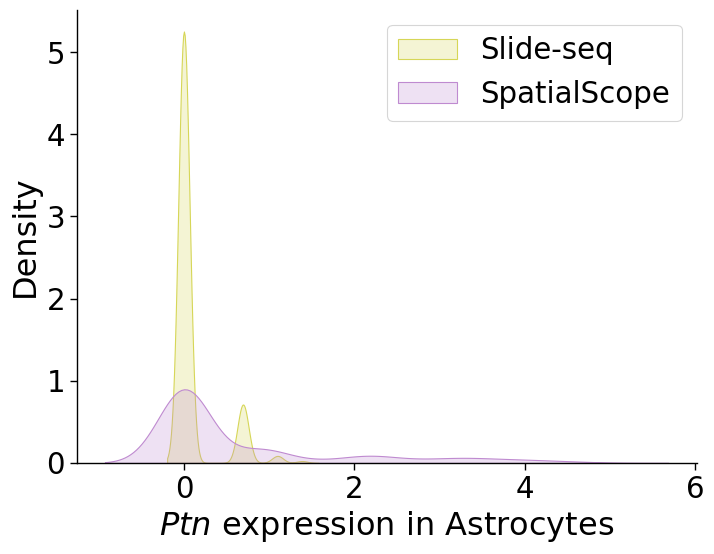

In [220]:
gene = L_gene
celltype = L_ct
sns.set_context('paper',font_scale=2.4)
fig, ax = plt.subplots(1, 1, figsize=(8, 6),dpi=100)
sns.kdeplot(data=ad_sp[ad_sp.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#D6D657',label='Slide-seq')
sns.kdeplot(data=ad_scst[ad_scst.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#BF8AD0',label='SpatialScope',clip=[-1,10])
ax.set_xlabel('${}$ expression in {}'.format(gene,celltype))
plt.legend(loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

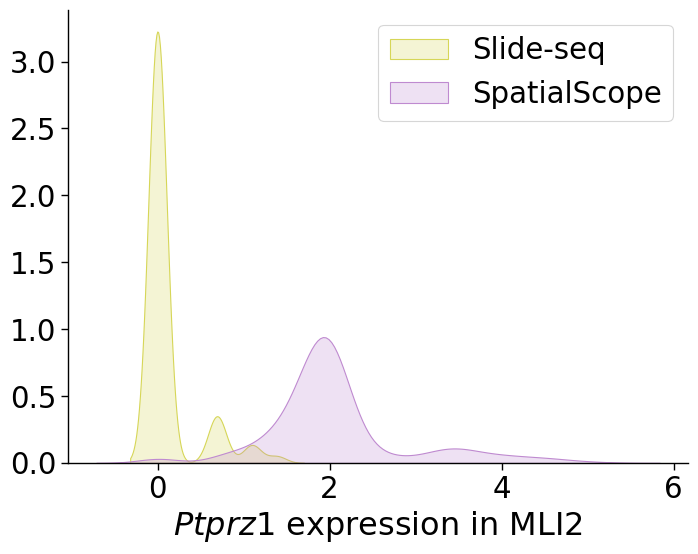

In [221]:
gene = R_gene
celltype = R_ct
sns.set_context('paper',font_scale=2.4)
fig, ax = plt.subplots(1, 1, figsize=(8, 6),dpi=100)
sns.kdeplot(data=ad_sp[ad_sp.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#D6D657',label='Slide-seq')
sns.kdeplot(data=ad_scst[ad_scst.obs['discrete_label_ct']==celltype,gene].to_df(), x=gene,ax=ax,fill=True,color='#BF8AD0',label='SpatialScope',clip=[-1,10])
ax.set_xlabel('${}$ expression in {}'.format(gene,celltype))
plt.legend(loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
plt.show()

## Comparison of cell counts between raw Slide-seq data and corrected Slide-seq data (Fig. i)

In [226]:
cellcounts = pd.DataFrame(ad_scst.obs.discrete_label_ct.value_counts()).merge(pd.DataFrame(ad_sp.obs.discrete_label_ct.value_counts()),how='left',right_index=True,left_index=True)
cellcounts = cellcounts.fillna(0)

In [227]:
cellcounts.head()

,discrete_label_ct_x,discrete_label_ct_y
Granule,6241,5737
Oligodendrocytes,1042,930
Purkinje,975,750
Bergmann,715,1435
Astrocytes,698,1066


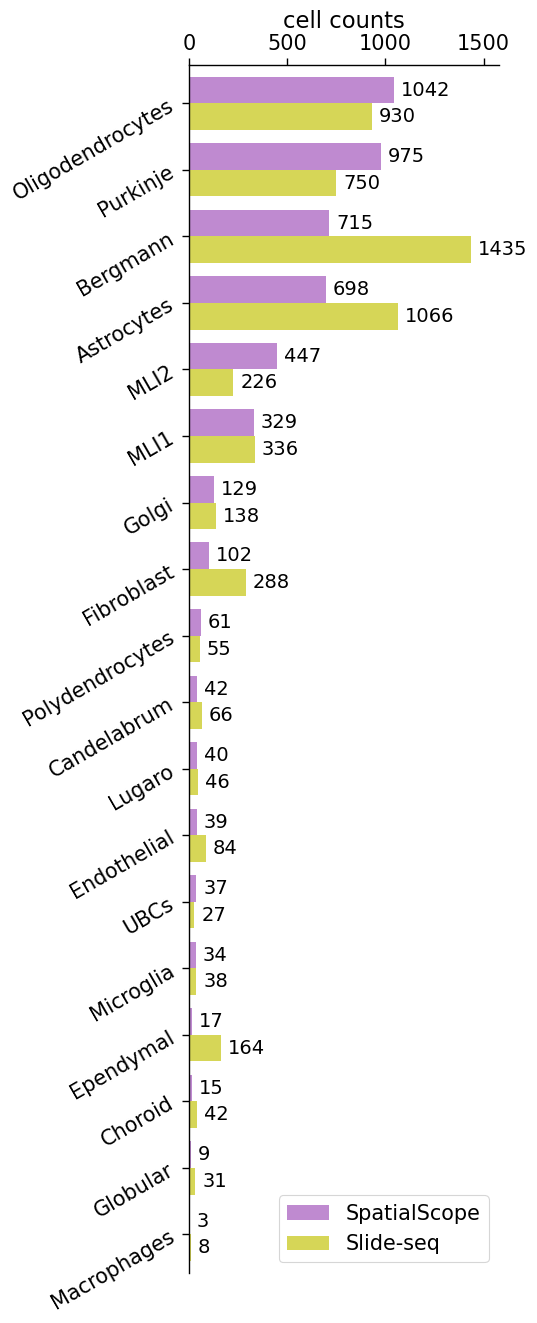

In [228]:
sns.set_context('paper',font_scale=1.7)
width=0.4
fig, ax = plt.subplots(1, 1, figsize=(4, 16), dpi=100)
#plt.figure()
ax.margins(0.1, 0.01) 
bars2 = ax.barh(np.arange(cellcounts.shape[0]-1)-width/2,cellcounts['discrete_label_ct_x'].values[1:],height=width,color='#BF8AD0',label='SpatialScope')
bars1 = ax.barh(np.arange(cellcounts.shape[0]-1)+width/2,cellcounts['discrete_label_ct_y'].values[1:],height=width,color='#D6D657',label='Slide-seq')
plt.yticks(np.arange(cellcounts.shape[0]-1))
ax.set_yticklabels(cellcounts.index.values[1:],rotation=30,ha='right')
plt.legend(loc=4)
#plt.ylabel('cell type')
plt.xlabel('cell counts')
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.bar_label(bars1,fontsize=14,padding=5)
ax.bar_label(bars2,fontsize=14,padding=5)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
plt.show()